In [1]:
#Import libraries and dependencies
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(32)
import get_model_portfolio_tickers as gmpt
import get_model_portfolio_weights as gmpw
import hvplot.pandas
import seaborn as sns

In [67]:
ticker = gmpt.get_model_portfolio_tickers('all_equity')
weights = gmpw.get_model_portfolio_weights('all_equity')

In [68]:
ticker

['VOO', 'VXF', 'VEA', 'VWO', 'FLRN']

In [69]:
weights


[0.488, 0.1, 0.301, 0.091, 0.02]

In [70]:
end_date = datetime.now()
start_date = end_date + timedelta(-1825)

# Get 5 year's worth of historical data for AAPL
df = get_historical_data(ticker, start_date, end_date,  output_format='pandas')
df.tail()

VOO                                      VXF                  \
              open    high     low   close   volume    open    high     low   
date                                                                          
2019-09-16  275.38  276.10  275.04  275.67  1432383  118.83  119.77  118.55   
2019-09-17  275.46  276.48  275.34  276.42  1791361  119.32  119.58  118.87   
2019-09-18  276.00  276.68  273.95  276.59  2030540  119.46  119.52  117.95   
2019-09-19  277.00  277.98  276.23  276.53  2272858  119.31  119.88  118.70   
2019-09-20  277.18  277.41  274.50  275.05  2063030  118.89  119.21  117.83   

                            ...    VWO                                  FLRN  \
             close  volume  ...   open   high    low  close    volume   open   
date                        ...                                                
2019-09-16  119.51  148505  ...  41.89  42.07  41.78  41.85   7936796  30.72   
2019-09-17  119.58  268380  ...  41.50  41.91  41.46  41.90  10816764  30.72   
2019-09-18  119.08  455378  ...  41.77  41.83  41.36  41.69  11450697  30.72   
2019-09-19  118.78  346961  ...  41.63  41.75  41.41  41.43  10264063  30.73   
2019-09-20  118.39  854993  ...  41.81  41.84  41.39  41.50  18953383  30.72   

                                          
             high    low  close   volume  
date                                      
2019-09-16  30.73  30.71  30.73   497704  
2019-09-17  30.72  30.69  30.71  1819252  
2019-09-18  30.73  30.71  30.72   473515  
2019-09-19  30.73  30.70  30.73   929746  
2019-09-20  30.73  30.71  30.72   859720  

[5 rows x 25 columns]

In [71]:
 # Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level = 1, inplace=True)
df.head()

,VOO,VXF,VEA,VWO,FLRN
,close,close,close,close,close
date,,,,,
2014-09-23,181.53,84.55,40.59,43.04,30.66
2014-09-24,182.99,85.14,40.60,43.26,30.65
2014-09-25,180.05,83.93,40.03,42.26,30.69
2014-09-26,181.50,84.59,40.18,42.53,30.65
2014-09-29,181.14,84.44,39.83,41.62,30.65


In [72]:
df = df.droplevel(1, axis = 1)

In [73]:
df

,VOO,VXF,VEA,VWO,FLRN
date,,,,,
2014-09-23,181.53,84.55,40.59,43.04,30.66
2014-09-24,182.99,85.14,40.60,43.26,30.65
2014-09-25,180.05,83.93,40.03,42.26,30.69
2014-09-26,181.50,84.59,40.18,42.53,30.65
2014-09-29,181.14,84.44,39.83,41.62,30.65
...,...,...,...,...,...
2019-09-16,275.67,119.51,41.47,41.85,30.73
2019-09-17,276.42,119.58,41.63,41.90,30.71
2019-09-18,276.59,119.08,41.52,41.69,30.72


In [74]:
daily_rteurns = df.pct_change().copy()
means = daily_rteurns.mean()
stds = daily_rteurns.std()
variances = daily_rteurns.var()
current_pirces = pd.DataFrame(df.iloc[-1])
current_pirces = current_pirces.transpose()
monte_carlo_cum_ret = pd.DataFrame()
    
       
    
    
for n in range(1000):

    #sets prices as current prices
    prices = current_pirces


    #Repeats simulation for "sim_days" times
    for i in range(252):

        #creates an empty dict to store simulated prices
        #of every ticker of a single day
        simulated_prices = {}


        #loops through every ticker last price availabe
        for stock,price in prices.iloc[-1].items():

            #sets a new random price assuming a normal distribution with the 
            #avarage and standard deviation obtained from prices dataframe 
            #new_price = price * (1 + np.random.normal(means[stock],stds[stock])) #old monte -carlo
            daily_drift = means[stock] - (variances[stock]/2)
            drift = daily_drift - 0.5 * stds[stock] ** 2
            diffusion = stds[stock] * np.random.laplace()
            new_price = price * np.exp(drift + diffusion)

            #Adds the key, value pair of the ticker with the new price simulated
            #to the simulated_prices dict.
            simulated_prices.update({stock : [new_price]})


        #Converts the dict to a dataframe to stack it up and build up 
        #the monte-carlo dataframe of a single simulation of "sim_days" days
        new_sim_prices_df = pd.DataFrame.from_dict(simulated_prices)
        prices = pd.concat([prices,new_sim_prices_df],axis = 0,ignore_index=True)
            
            

    #converts the dataframe of simulated prices into a daily return df
    simulated_daily_returns = prices.pct_change()

    #converts the portfolio of daily returns of different stocks into a
    #single-column dataframe of the total returns per day after applying weihgts
    portfolio_daily_returns = simulated_daily_returns.dot(weights)

    #stacks horizontally the single simulation result to build the final monte-carlo
    #dataframe after the "trials" trials.
    monte_carlo_cum_ret[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
        



    

In [75]:
monte_carlo_cum_ret.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.990214,1.001393,1.011629,1.017102,1.002030,0.996120,0.997426,1.002966,1.002673,1.000642,...,1.017977,1.004754,1.000910,1.003481,0.996788,0.995417,0.990340,0.990094,0.995381,0.987681
2,0.986441,0.999665,1.009980,1.017128,0.996521,0.997282,0.996338,1.002876,0.998383,0.996644,...,1.016076,1.009806,1.006664,0.998168,0.994806,0.988242,0.988923,0.991771,0.993989,1.007309
3,0.986655,1.002047,1.017334,1.026716,0.982958,0.997390,0.996542,1.002925,0.989665,0.988285,...,1.014911,1.015047,1.008618,1.005692,0.995686,0.982628,0.997150,0.993369,0.983730,1.013337
4,0.986031,1.019488,1.014147,1.031801,0.984961,0.997961,0.990751,1.003579,0.982248,0.981468,...,1.014969,1.005671,1.020324,1.007817,0.980964,0.975425,1.014381,0.982693,0.999895,1.021167


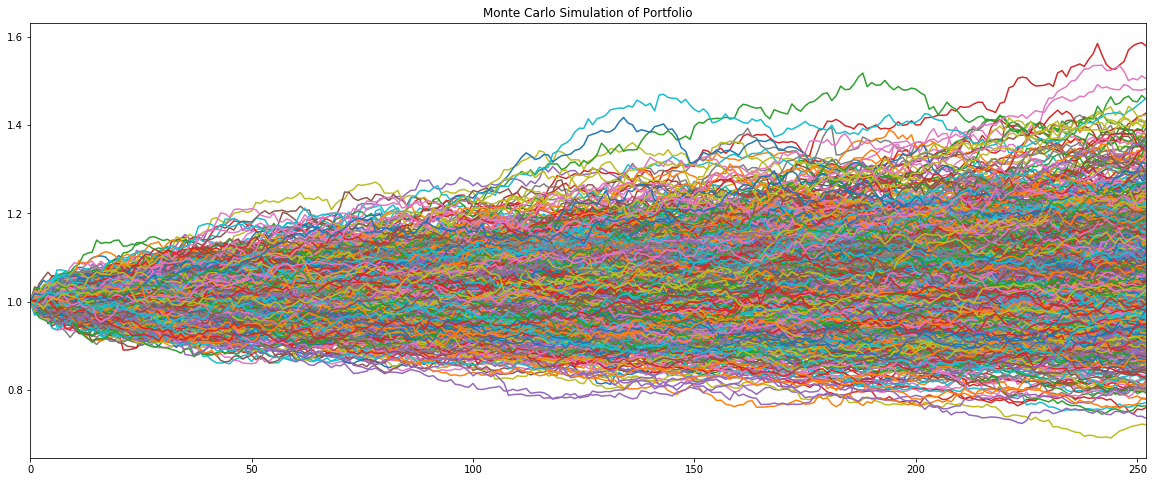

In [76]:

plot_title = f"Monte Carlo Simulation of Portfolio"
monte_carlo_sim_plot = monte_carlo_cum_ret.plot(title=plot_title,figsize=(20,8),legend=False)
monte_carlo_sim_plot


In [77]:
hist_daily_returns_df = daily_rteurns.dropna()
hist_daily_returns_df.to_csv("all_equity_hist_daily_returns.csv")


,VOO,VXF,VEA,VWO,BSV,BIV,BLV,VMBS,BNDX,FLRN
date,,,,,,,,,,
2014-09-24,0.008043,0.006978,0.000246,0.005112,-0.000125,-0.002020,-0.004558,-0.001523,-0.000577,-0.000326
2014-09-25,-0.016066,-0.014212,-0.014039,-0.023116,0.000625,0.003334,0.008153,0.002479,0.002500,0.001305
2014-09-26,0.008053,0.007864,0.003747,0.006389,-0.000499,-0.001780,-0.001108,-0.001712,-0.000959,-0.001303
2014-09-29,-0.001983,-0.001773,-0.008711,-0.021397,0.000250,0.001070,0.001220,0.002096,0.000576,0.000000
2014-09-30,-0.003036,-0.010185,-0.002009,0.002162,0.000000,0.000594,-0.000554,-0.000380,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2019-09-16,-0.003290,0.000921,-0.007182,-0.008059,0.001368,0.003459,0.008896,0.002077,0.002751,0.000000
2019-09-17,0.002721,0.000586,0.003858,0.001195,0.000745,0.001954,0.005311,-0.000188,0.000686,-0.000651
2019-09-18,0.000615,-0.004181,-0.002642,-0.005012,0.000124,0.000918,0.003987,0.000942,0.003256,0.000326


In [78]:
monte_carlo_cum_ret.to_csv("all_equity_cumulative_returns.csv")

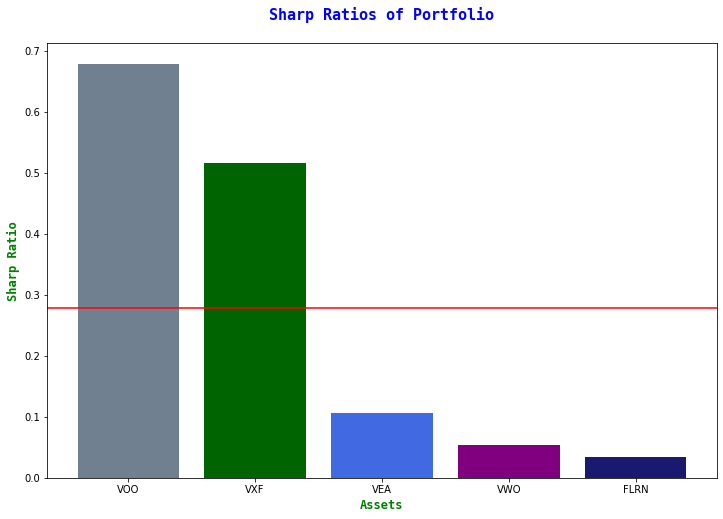

In [79]:

    
title_font = {'family': 'monospace',
        'color':  'blue',
        'weight': 'bold',
        'size': 15,
        }
label_font = {'family': 'monospace',
        'color':  'green',
        'weight': 'bold',
        'size': 12,
        }
   
bar_colors=["midnightblue","royalblue","indigo","darkcyan","darkgreen","maroon",
            "purple","darkorange","slategray","forestgreen"]

sharp_ratios = daily_rteurns.mean()*np.sqrt(252)/daily_rteurns.std()

sr_plot = plt.figure(figsize = (12,8));
plt.bar(x = sharp_ratios.index, height=sharp_ratios,  color=random.sample(bar_colors,len(sharp_ratios.index)))
plt.title(f"Sharp Ratios of Portfolio\n",fontdict=title_font)
plt.ylabel("Sharp Ratio",fontdict=label_font)
plt.xlabel("Assets",fontdict=label_font)
plt.axhline(sharp_ratios.mean(), color='r')

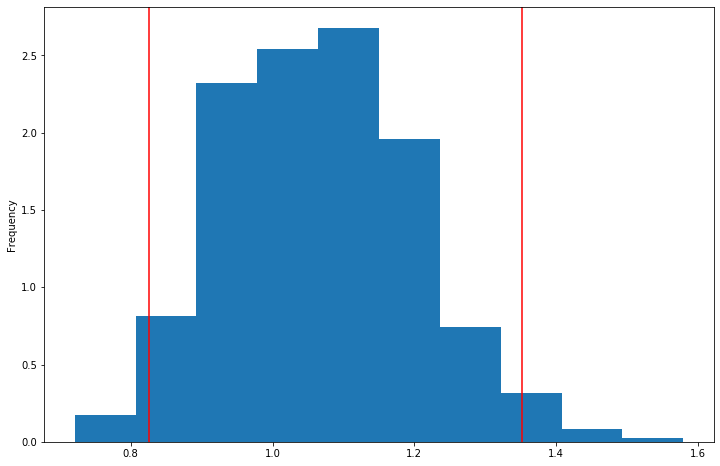

In [80]:
last_row_db = monte_carlo_cum_ret.iloc[-1,:]
confidence_interval = last_row_db.quantile(q=[0.025, 0.975])
plt.figure(figsize=(12,8));
last_row_db.plot( kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [81]:
confidence_interval

0.025    0.826413
0.975    1.351530
Name: 252, dtype: float64